# Case study

A fashion merchant (wholesale and retail) is operating out of stores in multiple regions. We have collected the sales and purchase data for the last few years. We wanted to use the same to answer some business questions to help improve the way we do business. For practical purposes assume that the inventory on the first purchase date available in the purchase_data.csv was 0.

## Prepare data

### Common imports and setup

In [ ]:
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

load_dotenv()

root_path = os.getenv("DATA_ROOT_PATH")
if not root_path:
    raise ValueError("The environment needs to be set")

root_path = root_path.rstrip("/\\")

pd.set_option("display.max_rows", None, "display.max_columns", None)

### Import data

In [126]:
stores = pd.read_csv(f'{root_path}/store_regions.csv')
display("Stores")
display(stores.head(3))

products = pd.read_csv(f'{root_path}/products.csv')
display("Products")
display(products.head(3))

purchases = pd.read_csv(f'{root_path}/purchase_data.csv')
display("Purchases")
display(purchases.head(3))

sales = pd.read_csv(f'{root_path}/sales_data.csv')
display("Sales")
display(sales.head(3))

data_dictionary = pd.read_csv(f'{root_path}/data_dictionary.csv')
display("Data Dictionary")
display(data_dictionary)

'Stores'

,N,S,E,W
0,Store1,Store5,Store4,Store2
1,Store3,Store6,Store7,NaN


'Products'

,Productid,ProductCategory,Occasion,Material,Karigari
0,100,Sarees,Festive,Pure silk,Zariwork
1,101,Sarees,Festive,Pure silk,Swarovski
2,102,Sarees,Festive,Pure silk,Sequins


'Purchases'

,Productid,UnitCost,UnitPrice,InboundInventory,PurchaseDate,Store,Region
0,100,23872.41,27692,40,2021-10-20,Store2,W
1,100,20733.33,24258,40,2021-12-27,Store3,N
2,100,8115.71,11362,40,2022-02-02,Store7,E


'Sales'

,Productid,OrderId,UnitsSold,Sales,SaleDate,Store,Region
0,100,1016,1,7329,2022-02-23,Store4,E
1,100,1006,1,24258,2022-04-03,Store3,N
2,100,1003,23,557934,2022-06-21,Store3,N


'Data Dictionary'

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,sales_data.csv,NaN,NaN,NaN,NaN,NaN,NaN
1,Productid,OrderId,UnitsSold,Sales,SaleDate,Store,Region
2,Uniquely identify product based on category an...,ID of the unique order placed by any customer....,Number of units of the mentioned productid pur...,Revenue generated by this product in this order.,Date on which the sale was made or the order w...,Store where the order was executed.,Region where the store is placed and order was...
3,purchase_data.csv,NaN,NaN,NaN,NaN,NaN,NaN
4,Productid,UnitCost,UnitPrice,InboundInventory,PurchaseDate,Store,Region
5,Uniquely identify product based on category an...,Cost to the merchant.,Price at which product is intended to be sold.,Number of units purchased. Which denotes how m...,Date when the item is expected in the inventory.,Store which made the purchase. This item would...,Region for this store.
6,products.csv,NaN,NaN,NaN,NaN,NaN,NaN
7,Productid,ProductCategory,Occasion,Material,Karigari,NaN,NaN
8,Uniquely identify product based on category an...,High level category to define the product. Thi...,General tag associated with the product to ind...,Cloth material used to make the product.,Type of handiwork done on the product.,NaN,NaN
9,store_regions.csv,"(The columns denote region names, North, south...",Row value indicate the names of the stores.,NaN,NaN,NaN,NaN


## Find missing values in the data sets

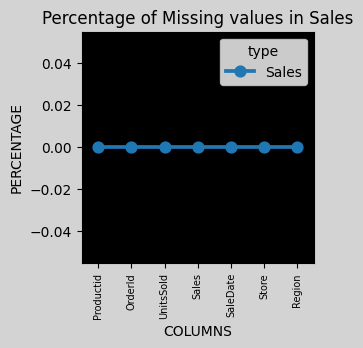

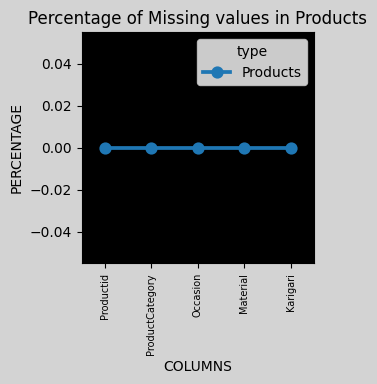

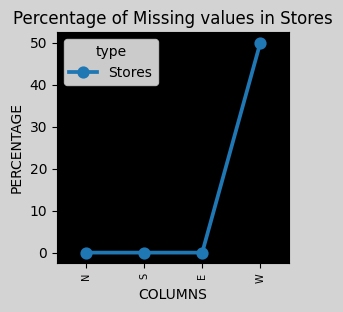

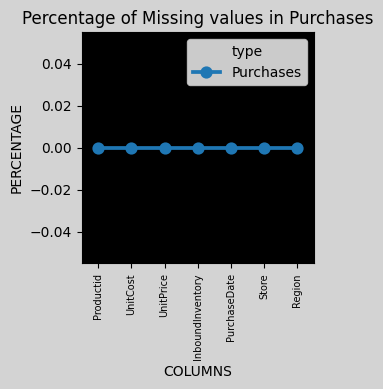

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns 

def plot_missing_values(df, type):
    fig = plt.figure(figsize=(3,3))
    new_df = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
    new_df["type"] = type

    ax = sns.pointplot(x="index", y=0, data=new_df, hue="type")
    plt.xticks(rotation=90, fontsize=7)
    plt.title(f"Percentage of Missing values in {type}")
    plt.ylabel("PERCENTAGE")
    plt.xlabel("COLUMNS")
    ax.set_facecolor("k")
    fig.set_facecolor("lightgrey")
    plt.show()

plot_missing_values(sales, "Sales")
plot_missing_values(products, "Products")
plot_missing_values(stores, "Stores")
plot_missing_values(purchases, "Purchases")


## Analysis

### Aggregate sales data

In [128]:
sales['SaleDate'] = pd.to_datetime(sales['SaleDate'])
sales['YearMonth'] = sales['SaleDate'].dt.to_period('M').astype(str)
sales_aggregated = sales.groupby(['Productid', 'YearMonth']).agg(
    TotalUnitsSold=('UnitsSold', 'sum'),
    TotalSales=('Sales', 'sum')
).reset_index()

# Calculate the total sales for each month
monthly_sales_totals = sales.groupby('YearMonth')['Sales'].sum().reset_index()
monthly_sales_totals.rename(columns={'Sales': 'MonthlyTotalSales'}, inplace=True)

# Merge the monthly totals back into the sales_aggregated dataframe
sales_aggregated = sales_aggregated.merge(monthly_sales_totals, on='YearMonth', how='left')

# Calculate the percentage of total sales per product for each month
sales_aggregated['SalesPercentage'] = (sales_aggregated['TotalSales'] / sales_aggregated['MonthlyTotalSales']) * 100

product_data = {
    "TotalUnitsSold": True, 
    "SalesPercentage": True,
    "Productid": True, 
    "YearMonth": False, 
    "ProductCategory": True, 
    "Occasion": True, 
    "Material": True, 
    "Karigari": True
}

sales_aggregated = sales_aggregated.merge(products, on='Productid', how='left')

# Identify the last month in the dataset
last_month = sales_aggregated['YearMonth'].max()
display(f"Last month: {last_month}")

# Filter data for only the last month
df_last_month = sales_aggregated[sales_aggregated['YearMonth'] == last_month]
display(df_last_month.head(3))

# Find top 5 products in the last month by TotalSales
top_5_products_last_month = df_last_month.nlargest(5, 'TotalSales')['Productid']

# Filter the original aggregated data to include only the top 5 products from the last month
df_top_5_last_month = sales_aggregated[sales_aggregated['Productid'].isin(top_5_products_last_month)]

# Display total number of records for last month
display(f"Total records for last month: {df_last_month.shape[0]}")



'Last month: 2024-04'

,Productid,YearMonth,TotalUnitsSold,TotalSales,MonthlyTotalSales,SalesPercentage,ProductCategory,Occasion,Material,Karigari
18,100,2024-04,3,72774,61752780,0.117847,Sarees,Festive,Pure silk,Zariwork
38,101,2024-04,32,229964,61752780,0.372395,Sarees,Festive,Pure silk,Swarovski
53,103,2024-04,3,69075,61752780,0.111857,Sarees,Festive,Georgette,Zariwork


'Total records for last month: 52'

### Top 5 products sold through time

In [129]:
# Calculate total units sold by each Productid across all months
total_sales = sales_aggregated.groupby('Productid')['TotalSales'].sum()

# Get top 5 Productid by total units sold
top_5_products = total_sales.nlargest(5).index

# Filter to only include data for the top 5 products
df_top_5 = sales_aggregated[sales_aggregated['Productid'].isin(top_5_products)]

fig = px.line(
    df_top_5,
    x="YearMonth",
    y="TotalSales",
    color="Productid",
    markers=True,
    hover_data=product_data
)

# Customize layout
fig.update_layout(
    title="Total Sales by Month (Top 5 Products)",
    xaxis_title="Month-Year",
    yaxis_title="Total Sales",
    hovermode="closest"
)

fig.show()

### Top 5 most sold products in the last month

In [130]:
# Plot with Plotly
fig = px.line(
    df_top_5_last_month,
    x="YearMonth",
    y="TotalSales",
    color="Productid",
    markers=True,
    hover_data=product_data
)

# Customize layout
fig.update_layout(
    title="Total Sales (Top 5 Products in Last Month)",
    xaxis_title="Month-Year",
    yaxis_title="Total Sales",
    hovermode="closest"
)

fig.show()


From the previous graph, Product with ID `156` was the one that was both the one that sold the most units and the one that generated the more revenue. This product is however not the one of the top 5 that have generated the most revenue through time, which might indicate that there was a recent event which caused its popularity to grow recently.

### View of "best selling" products of last month

In [131]:
fig = px.treemap(data_frame=df_last_month,
                path=[px.Constant('<b> Products'), 
                      'Productid'], 
                title = '<b> Best Selling Products (last month)',
                values= 'TotalUnitsSold', 
                hover_data=product_data)

fig.data[0].textinfo = 'label+text+value'

fig.update_traces(root_color='lightgrey')
 
fig.update_layout(treemapcolorway = ['burlywood', 'cadetblue'], 
                  margin = dict(t=50, l=20, r=20, b=20))

fig.layout.hovermode = 'closest'
fig.show()

### View of revenue by products of last month

In [132]:
fig = px.treemap(data_frame=df_last_month,
                path=[px.Constant('<b> Products'), 
                      'Productid'], 
                title = '<b> Products revenue (last month)',
                values= 'TotalSales',
                hover_data=product_data)

fig.data[0].textinfo = 'label+text+value'

fig.update_traces(root_color='lightgrey')
 
fig.update_layout(treemapcolorway = ['burlywood', 'cadetblue'], 
                  margin = dict(t=50, l=20, r=20, b=20))

fig.layout.hovermode = 'closest'
fig.show()

## Best selling product analysis (Product ID 156)

### Impute missing sales data

In [133]:
best_selling_product = df_last_month.nlargest(1, 'TotalUnitsSold')['Productid'].values[0]

df_best_product = sales_aggregated[sales_aggregated['Productid'] == best_selling_product].sort_values(by='YearMonth')
df_best_product['YearMonth'] = pd.to_datetime(df_best_product['YearMonth'])

df_best_product_raw = df_best_product

all_months = pd.date_range(start=df_best_product['YearMonth'].min(),
                           end=df_best_product['YearMonth'].max(),
                           freq='MS')  # 'MS' means Month Start

complete_data = pd.DataFrame({
    'YearMonth': all_months,
    'Productid': df_best_product['Productid'].iloc[0]  # Assuming single product
})

df_best_product = pd.merge(complete_data, df_best_product, on=['YearMonth', 'Productid'], how='left').fillna(0)


### Add inventory information to the data frame

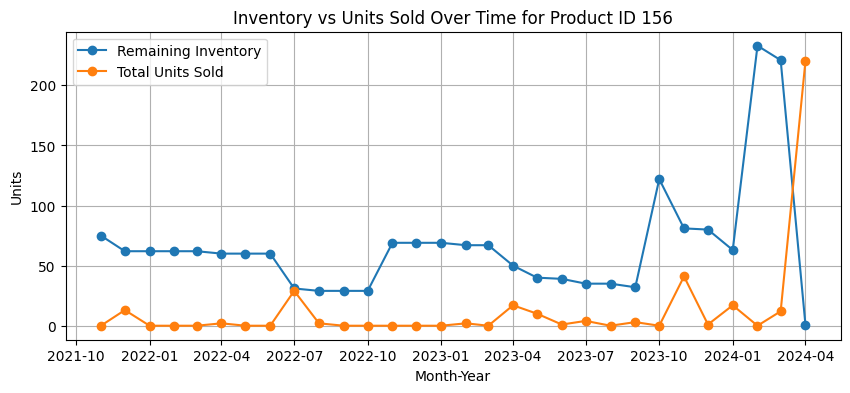

In [134]:
purchases['PurchaseDate'] = pd.to_datetime(purchases['PurchaseDate'])
purchases['YearMonth'] = purchases['PurchaseDate'].dt.to_period('M').dt.to_timestamp()

purchases_aggregated = purchases.groupby(['Productid', 'YearMonth']).agg(
    TotalInboundInventory=('InboundInventory', 'sum')
).reset_index()

df_purchases_best_product = purchases_aggregated[purchases_aggregated['Productid'] == best_selling_product].sort_values(by='YearMonth')

# dates for purchases start before sales data, we need to prepare the data before joining
start_date = min(df_best_product['YearMonth'].min(), df_purchases_best_product['YearMonth'].min())
end_date = max(df_best_product['YearMonth'].max(), df_purchases_best_product['YearMonth'].max())
all_months = pd.date_range(start=start_date, end=end_date, freq='MS')

df_full = pd.DataFrame({'YearMonth': all_months, 'Productid': best_selling_product})
df_combined = pd.merge(df_full, df_best_product, on=['Productid', 'YearMonth'], how='left')
df_combined = pd.merge(df_combined, df_purchases_best_product, on=['Productid', 'YearMonth'], how='left')

# Fill missing values for TotalUnitsSold and TotalInboundInventory with 0
df_combined['TotalUnitsSold'] = df_combined['TotalUnitsSold'].fillna(0)
df_combined['TotalInboundInventory'] = df_combined['TotalInboundInventory'].fillna(0)

# Fill missing InboundInventory with 0 for months with no new purchases
df_combined['TotalInboundInventory'] = df_combined['TotalInboundInventory'].fillna(0)

# Calculate cumulative inventory
df_combined['CumulativeInventory'] = df_combined['TotalInboundInventory'].cumsum()

# Subtract TotalUnitsSold each month from the cumulative inventory
df_combined['RemainingInventory'] = df_combined['CumulativeInventory'] - df_combined['TotalUnitsSold'].cumsum()

# Ensure RemainingInventory doesn’t go below zero
df_combined['RemainingInventory'] = df_combined['RemainingInventory'].clip(lower=0)

plt.figure(figsize=(10, 4))
plt.plot(df_combined['YearMonth'], df_combined['RemainingInventory'], marker='o', label='Remaining Inventory')
plt.plot(df_combined['YearMonth'], df_combined['TotalUnitsSold'], marker='o', label='Total Units Sold')
plt.title(f'Inventory vs Units Sold Over Time for Product ID {best_selling_product}')
plt.xlabel('Month-Year')
plt.ylabel('Units')
plt.legend()
plt.grid(True)
plt.show()


From this analysis, it seems the company knew there was going to be more demand for this product as they stocked up a few months before they saw a huge increase in sales. This could either be due to more demand on the product due to external factors or maybe because there was a marketing campaign done by the company which caused the product to be more popular.

### Moving Average

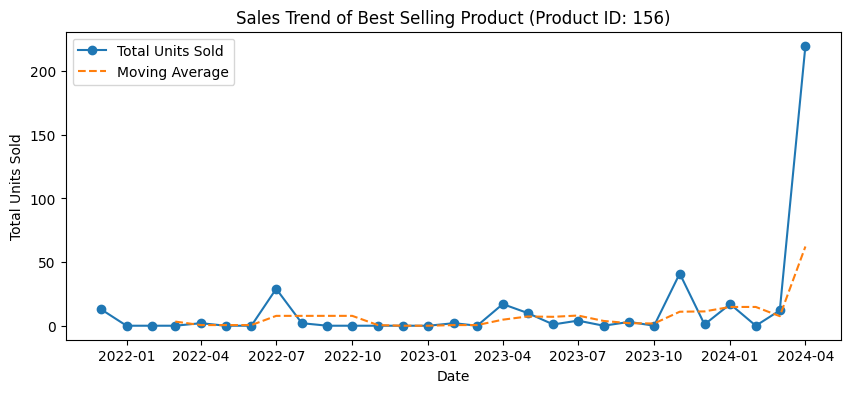

In [135]:
# Plotting Total Units Sold with Moving Average Trend
plt.figure(figsize=(10, 4))
df_best_product['MovingAverage'] = df_best_product['TotalUnitsSold'].rolling(window=4).mean()  # 2-month moving average
plt.plot(df_best_product['YearMonth'], df_best_product['TotalUnitsSold'], marker='o', label='Total Units Sold')
plt.plot(df_best_product['YearMonth'], df_best_product['MovingAverage'], linestyle='--', label='Moving Average')

plt.title(f'Sales Trend of Best Selling Product (Product ID: {best_selling_product})')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.legend()
plt.show()


From this trend, it appears that the growth has been stable through time with some slow growth.

### Growth Trend

#### Forward-fill approach (using original data, without the impute on the missing months)

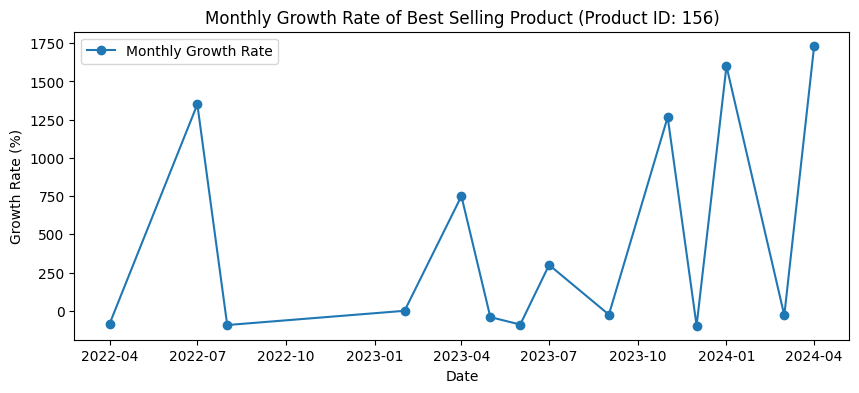

In [136]:
# Percentage Growth Calculation for the best-selling product
df_best_product_raw['PrevTotalUnitsSold'] = df_best_product_raw['TotalUnitsSold'].shift(1)
df_best_product_raw['GrowthRate'] = ((df_best_product_raw['TotalUnitsSold'] - df_best_product_raw['PrevTotalUnitsSold']) / df_best_product_raw['PrevTotalUnitsSold']) * 100

# Plotting the Growth Rate
plt.figure(figsize=(10, 4))
plt.plot(df_best_product_raw['YearMonth'], df_best_product_raw['GrowthRate'], marker='o', label='Monthly Growth Rate')

plt.title(f'Monthly Growth Rate of Best Selling Product (Product ID: {best_selling_product})')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.show()


#### Old = 1 approach (using imputed data)

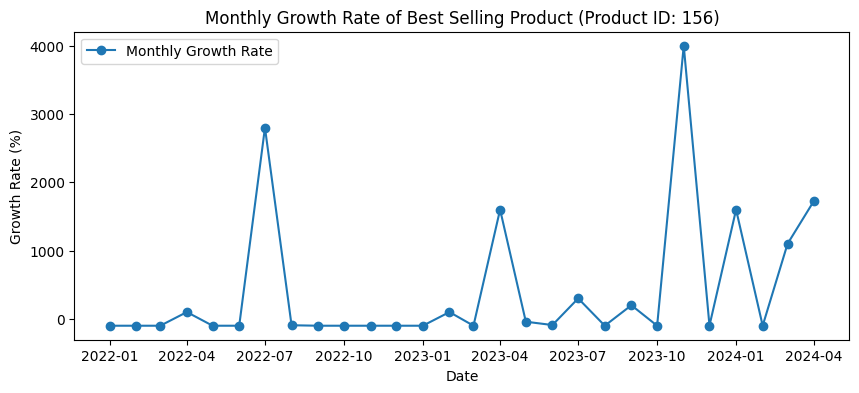

In [137]:
# Percentage Growth Calculation for the best-selling product
df_best_product['PrevTotalUnitsSold'] = np.where(
    df_best_product['TotalUnitsSold'].shift(1) == 0,
    1,
    df_best_product['TotalUnitsSold'].shift(1)
)
df_best_product['GrowthRate'] = ((df_best_product['TotalUnitsSold'] - df_best_product['PrevTotalUnitsSold']) / df_best_product['PrevTotalUnitsSold']) * 100

# Plotting the Growth Rate
plt.figure(figsize=(10, 4))
plt.plot(df_best_product['YearMonth'], df_best_product['GrowthRate'], marker='o', label='Monthly Growth Rate')

plt.title(f'Monthly Growth Rate of Best Selling Product (Product ID: {best_selling_product})')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.show()


The growth trend shows fluctuation, the moving average seems to be a better metric as it smooths some of the variations that may happen month by month. The fluctuation does not seem to have been caused due to inventory shortages as there was plenty of inventory, this product seems to have more demand on some months.

A pattern seems to be that on the months of April and July there is always more demand for this item, for April there's a steady growth from 2022 to 2023 and 2023, for July there was demand on 2023 as well but it was less than it was for 2022. No data yet for July 2024 to compare but at least April seems to be a good month for this product.

### Linear regression trend

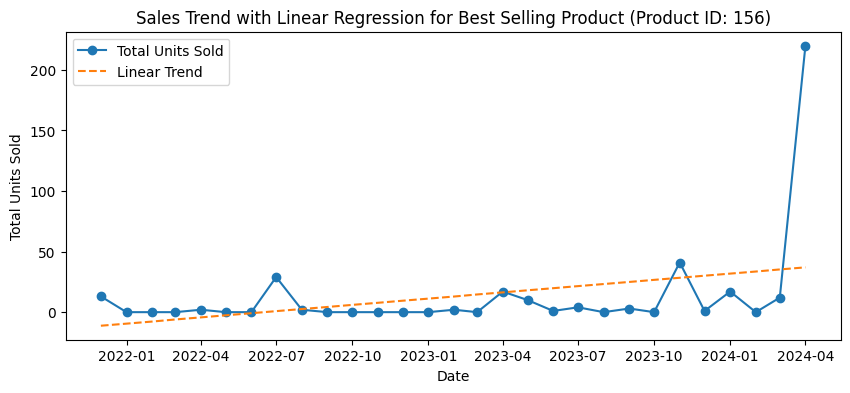

In [138]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(10, 4))
x = np.array(range(len(df_best_product))).reshape(-1, 1)  # Use index as a time variable
y = df_best_product['TotalUnitsSold'].values
model = LinearRegression().fit(x, y)
trend = model.predict(x)

plt.plot(df_best_product['YearMonth'], y, marker='o', label='Total Units Sold')
plt.plot(df_best_product['YearMonth'], trend, linestyle='--', label='Linear Trend')

plt.title(f'Sales Trend with Linear Regression for Best Selling Product (Product ID: {best_selling_product})')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.legend()
plt.show()

<Figure size 1000x400 with 0 Axes>

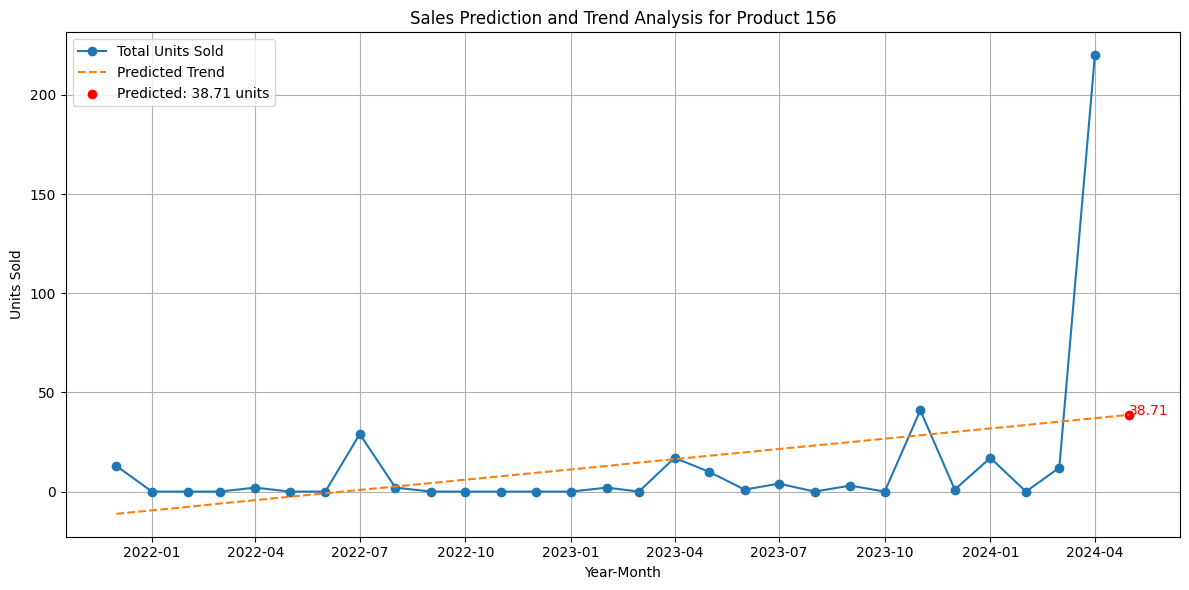

In [139]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(10, 4))
x = np.array(range(len(df_best_product))).reshape(-1, 1)  # Use index as a time variable
y = df_best_product['TotalUnitsSold'].values
model = LinearRegression().fit(x, y)
model.fit(x, y)

# Predict the trend for the next month
next_month = np.array([[len(df_best_product)]])  # Predict for the next month
predicted_next = model.predict(next_month)[0]

# Prepare data for visualization
df_best_product["PredictedTrend"] = model.predict(x)
df_best_product = df_best_product.reset_index(drop=True)

# Extend DataFrame for the next month
next_month_data = {
    "YearMonth": [df_best_product["YearMonth"].iloc[-1] + pd.DateOffset(months=1)],
    "TotalUnitsSold": [np.nan],  # No actual sales data
    "PredictedTrend": [predicted_next],
    "GrowthRate": [np.nan],  # Growth for predicted data is undefined
}
df_best_product_trend = pd.concat([df_best_product, pd.DataFrame(next_month_data)], ignore_index=True)

# Plot the data
plt.figure(figsize=(12, 6))

# Plot total units sold and predicted trend
plt.plot(df_best_product_trend["YearMonth"], df_best_product_trend["TotalUnitsSold"], label="Total Units Sold", marker="o")
plt.plot(df_best_product_trend["YearMonth"], df_best_product_trend["PredictedTrend"], label="Predicted Trend", linestyle="--")

# Annotate the predicted next month's sales
plt.scatter(df_best_product_trend["YearMonth"].iloc[-1], predicted_next, color="red", label=f"Predicted: {predicted_next:.2f} units")
plt.text(df_best_product_trend["YearMonth"].iloc[-1], predicted_next, f"{predicted_next:.2f}", ha="left", color="red")

# Customize the plot
plt.title("Sales Prediction and Trend Analysis for Product 156")
plt.xlabel("Year-Month")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Store profitability analysis

### Compare the unit cost for each product across all stores

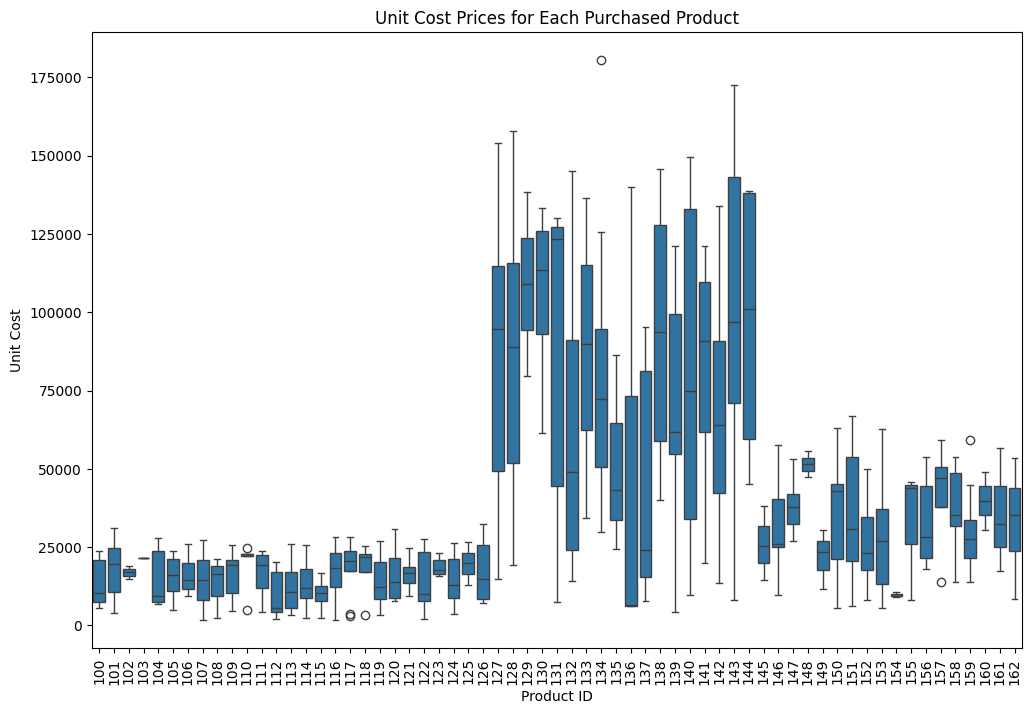

In [140]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Productid', y='UnitCost', data=purchases)
plt.title('Unit Cost Prices for Each Purchased Product')
plt.xlabel('Product ID')
plt.ylabel('Unit Cost')
plt.xticks(rotation=90)
plt.show()


### Analyze the distribution of unit costs per store

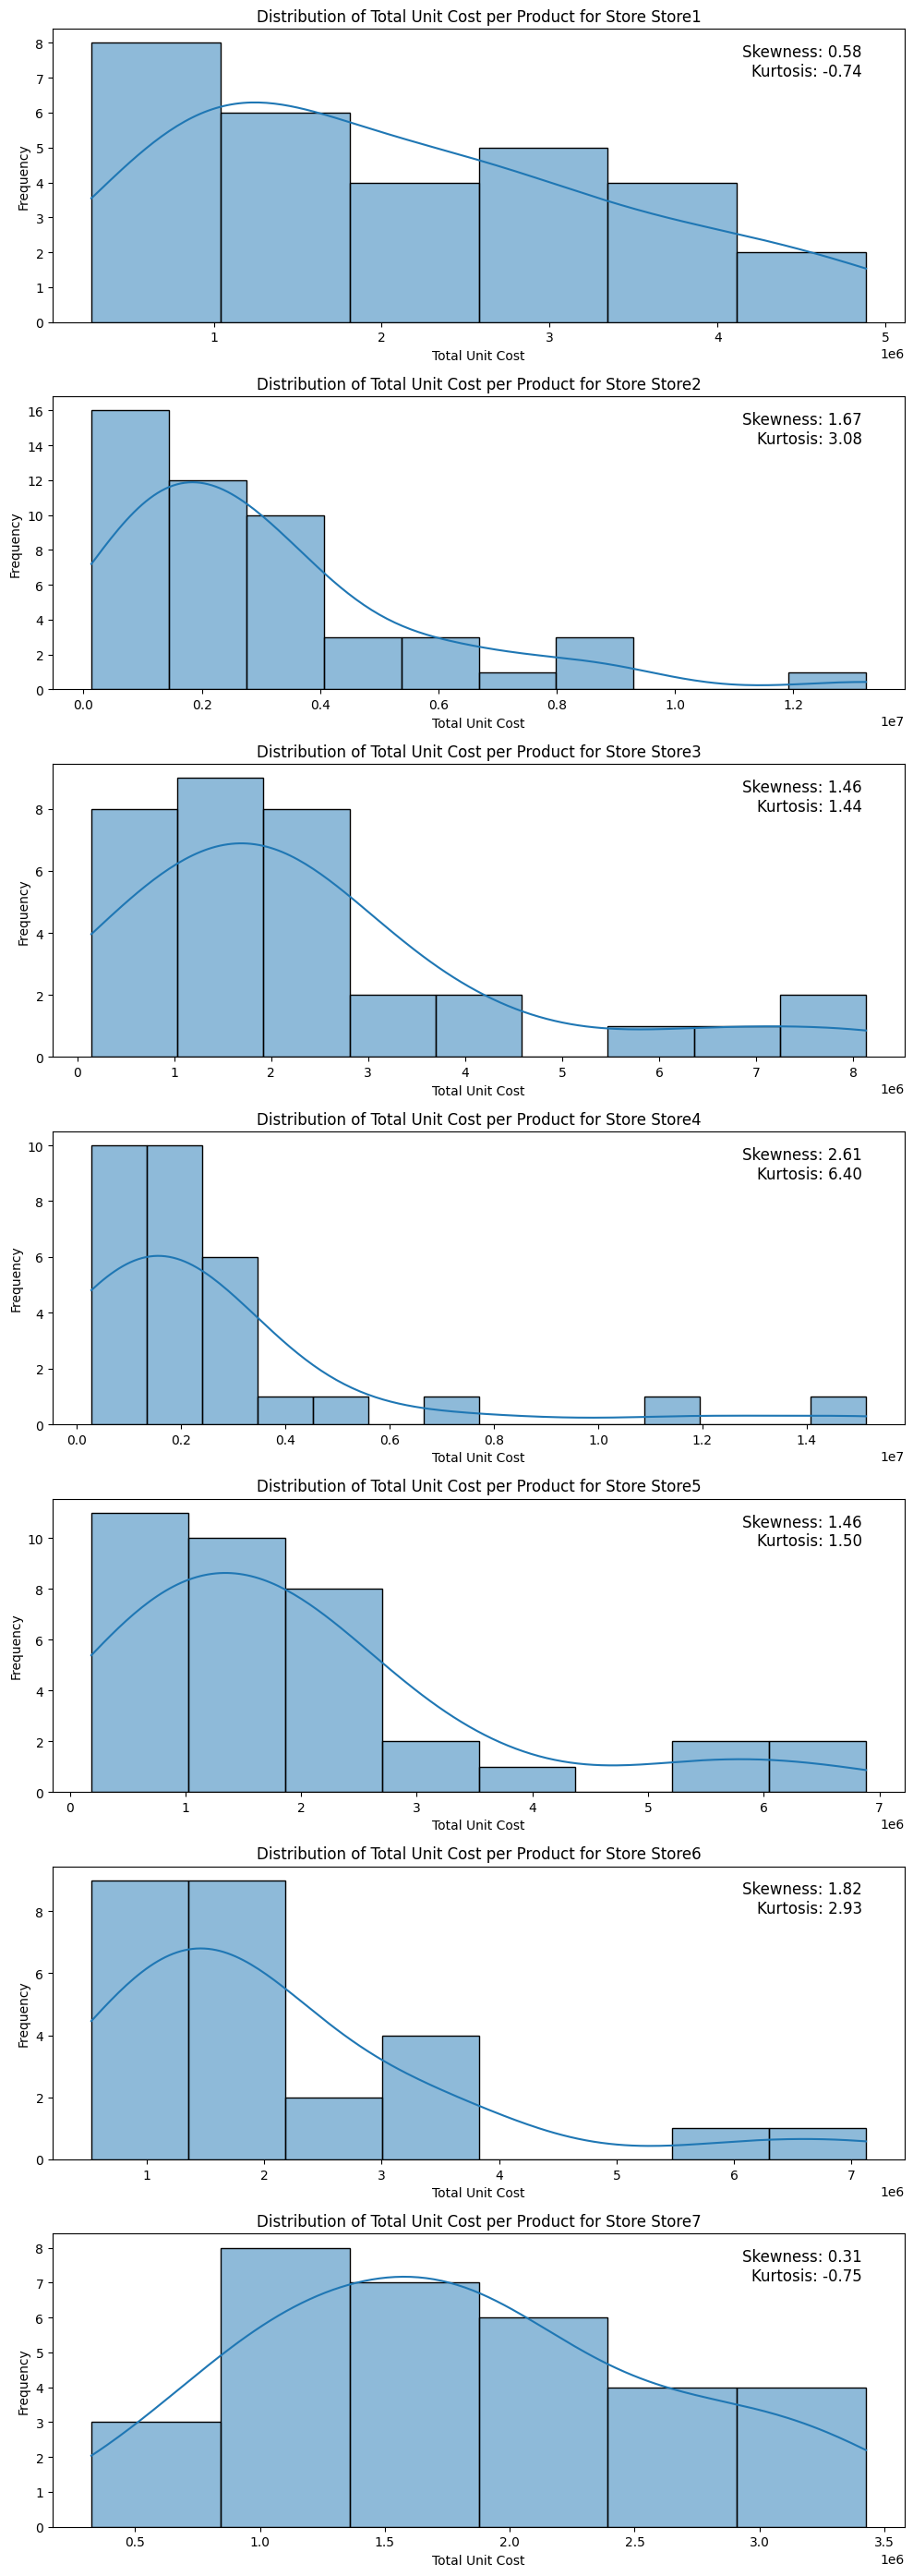

In [141]:
from scipy.stats import skew, kurtosis

# Filter products that have been sold in each store
sold_products_per_store = sales.groupby('Store')['Productid'].unique()

# Calculate the total unit cost of purchase per product per store
purchases['TotalUnitCost'] = purchases['UnitCost'] * purchases['InboundInventory']
total_unit_cost_per_product_store = purchases.groupby(['Store', 'Productid'])['TotalUnitCost'].sum().reset_index()

# Filter the total unit cost data to include only sold products
filtered_total_unit_cost = total_unit_cost_per_product_store[
    total_unit_cost_per_product_store.apply(lambda row: row['Productid'] in sold_products_per_store[row['Store']], axis=1)
]

# Plot the distribution for each store
stores_data = filtered_total_unit_cost['Store'].unique()
fig, axes = plt.subplots(len(stores_data), 1, figsize=(10, 4 * len(stores_data)))

for i, store in enumerate(stores_data):
    store_data = filtered_total_unit_cost[filtered_total_unit_cost['Store'] == store]['TotalUnitCost']
    sns.histplot(store_data, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of Total Unit Cost per Product for Store {store}')
    axes[i].set_xlabel('Total Unit Cost')
    axes[i].set_ylabel('Frequency')
    axes[i].text(0.95, 0.95, f'Skewness: {skew(store_data):.2f}\nKurtosis: {kurtosis(store_data):.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

### Determine profitability by store (Median Store Unit Cost approach)

,Store,Region,TotalUnitsSold,TotalSales,MedianStoreUnitCost,COGS,Profit,ProfitMargin
0,Store1,N,2191,73182477,23304.240,5.105959e+07,2.212289e+07,30.229760
1,Store2,W,4816,176275560,26784.935,1.289962e+08,4.727931e+07,26.821252
2,Store3,N,2443,98496441,23176.030,5.661904e+07,4.187740e+07,42.516663
3,Store4,E,2501,96124741,23605.145,5.903647e+07,3.708827e+07,38.583483
4,Store5,S,2395,89116829,26445.080,6.333597e+07,2.578086e+07,28.929286
5,Store6,S,2125,65982795,24084.290,5.117912e+07,1.480368e+07,22.435665
6,Store7,E,2558,68940189,21758.875,5.565920e+07,1.328099e+07,19.264506


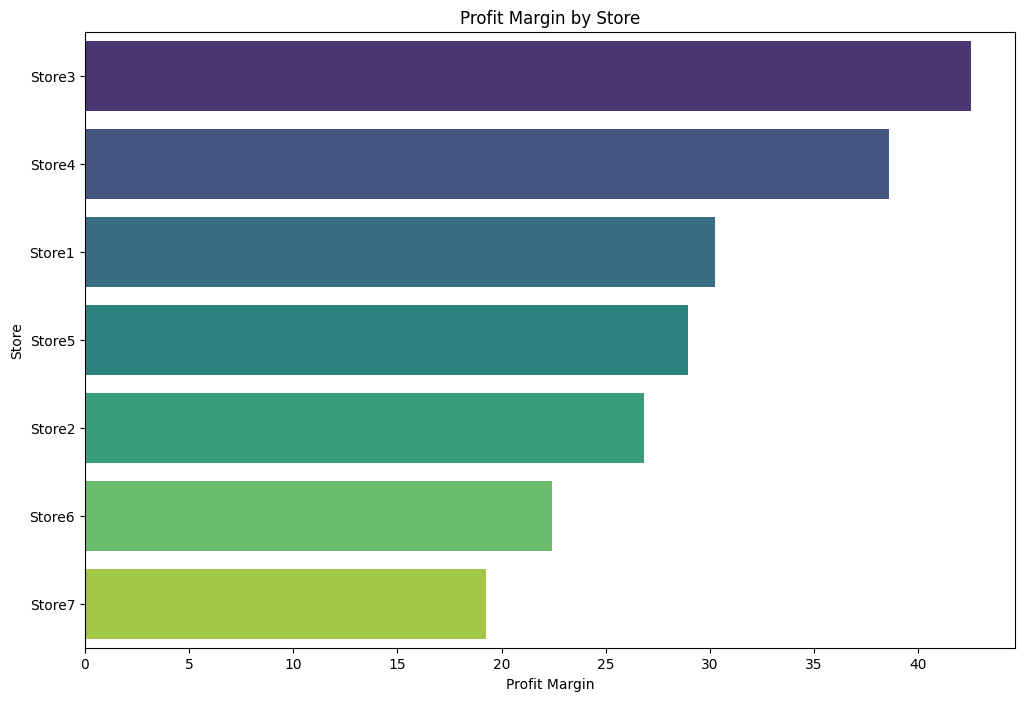

In [142]:
# Aggregate sales data by store
sales_by_store = sales.groupby(['Store', 'Region']).agg(
    TotalUnitsSold=('UnitsSold', 'sum'),
    TotalSales=('Sales', 'sum')
).reset_index()

# Calculate the Median Store Unit Cost
sales_by_store['MedianStoreUnitCost'] = purchases.groupby('Store')['UnitCost'].median().reindex(sales_by_store['Store']).values

# Calculate COGS (Cost of Goods Sold) for each store
sales_by_store['COGS'] = sales_by_store['TotalUnitsSold'] * sales_by_store['MedianStoreUnitCost']

# Calculate profit for each store
sales_by_store['Profit'] = sales_by_store['TotalSales'] - sales_by_store['COGS']

# Calculate profit margin for each store
sales_by_store['ProfitMargin'] = (sales_by_store['Profit'] / sales_by_store['TotalSales']) * 100

# Sort stores by profit margin
sales_by_store_sorted = sales_by_store.sort_values(by='ProfitMargin', ascending=False)

display(sales_by_store)

# Plot the profit margins
plt.figure(figsize=(12, 8))
sns.barplot(x='ProfitMargin', y='Store', data=sales_by_store_sorted, palette='viridis', hue='Store', legend=False)
plt.title('Profit Margin by Store')
plt.xlabel('Profit Margin')
plt.ylabel('Store')
plt.show()

Store3 is the most profitable store with a margin of 42.5% while Store7 is the least profitable with a margin of 19.3%

### Determine profitability by store (Weighted Average Cost Per Product approach)

,Store,TotalUnitsSold,TotalSales,COGS,Profit,ProfitMargin
0,Store1,2191,73182477,5.532200e+07,1.786048e+07,24.405401
1,Store2,4816,176275560,1.378094e+08,3.846611e+07,21.821579
2,Store3,2443,98496441,7.216121e+07,2.633524e+07,26.737246
3,Store4,2501,96124741,8.432899e+07,1.179575e+07,12.271292
4,Store5,2395,89116829,7.101131e+07,1.810552e+07,20.316613
5,Store6,2125,65982795,6.129987e+07,4.682929e+06,7.097196
6,Store7,2558,68940189,6.620070e+07,2.739489e+06,3.973718


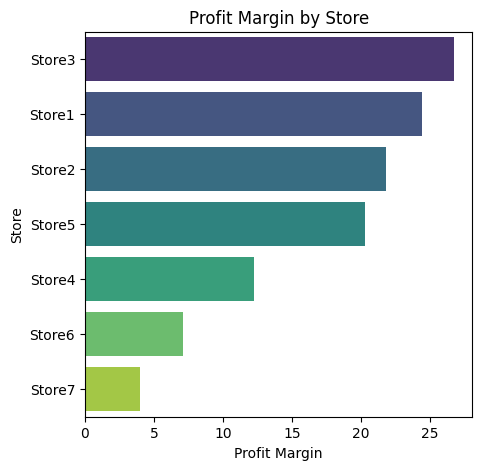

In [143]:
# Calculate the Weighted Average Cost per unit for each product
purchases['TotalCost'] = purchases['UnitCost'] * purchases['InboundInventory']
weighted_avg_cost = purchases.groupby('Productid').apply(
    lambda x: x['TotalCost'].sum() / x['InboundInventory'].sum(), 
    include_groups=False
).reset_index(name='WeightedAvgCost')

# Track sales by product per store
sales_by_store_product = sales.groupby(['Store', 'Productid']).agg(
    TotalUnitsSold=('UnitsSold', 'sum'),
    TotalSales=('Sales', 'sum')
).reset_index()

# Calculate COGS using the Weighted Average Cost for each product sold, then aggregate results per store
sales_by_store_product = sales_by_store_product.merge(weighted_avg_cost, on='Productid', how='left')
sales_by_store_product['COGS'] = sales_by_store_product['TotalUnitsSold'] * sales_by_store_product['WeightedAvgCost']
sales_by_store = sales_by_store_product.groupby('Store').agg(
    TotalUnitsSold=('TotalUnitsSold', 'sum'),
    TotalSales=('TotalSales', 'sum'),
    COGS=('COGS', 'sum')
).reset_index()

# Calculate profit for each store
sales_by_store['Profit'] = sales_by_store['TotalSales'] - sales_by_store['COGS']

# Calculate profit margin for each store
sales_by_store['ProfitMargin'] = (sales_by_store['Profit'] / sales_by_store['TotalSales']) * 100

# Sort stores by profit margin
sales_by_store_sorted = sales_by_store.sort_values(by='ProfitMargin', ascending=False)

display(sales_by_store)

# Plot the profit margins
plt.figure(figsize=(5, 5))
sns.barplot(x='ProfitMargin', y='Store', data=sales_by_store_sorted, palette='viridis', hue='Store', legend=False)
plt.title('Profit Margin by Store')
plt.xlabel('Profit Margin')
plt.ylabel('Store')
plt.show()

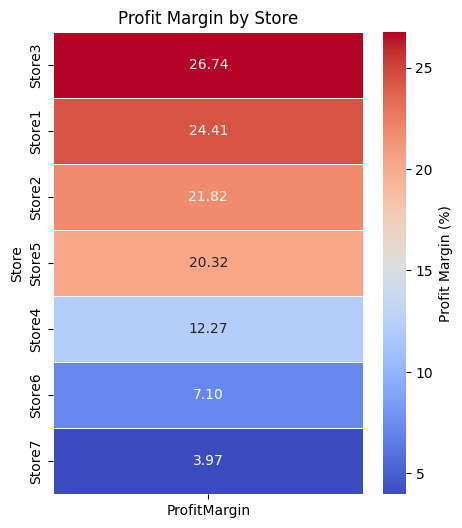

In [144]:
# Prepare data for heatmap
heatmap_data = sales_by_store_sorted[["Store", "ProfitMargin"]].set_index("Store")

# Plot heatmap
plt.figure(figsize=(5, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"label": "Profit Margin (%)"},
)

plt.title("Profit Margin by Store")
plt.ylabel("Store")
plt.show()

Store3 is the most profitable store with a margin of 26.7% while Store7 is the least profitable with a margin of 3.9%

### Analyze profitability of products for Store7 (least profitable store)

In [145]:
# Filter sales data for Store3 and the last 3 months
last_3_months = sales['SaleDate'].max() - pd.DateOffset(months=3)
sales_store_last_3_months = sales[(sales['Store'] == 'Store7') & (sales['SaleDate'] >= last_3_months)]

# Aggregate sales data by product
sales_store_aggregated = sales_store_last_3_months.groupby('Productid').agg(
    TotalUnitsSold=('UnitsSold', 'sum'),
    TotalSales=('Sales', 'sum')
).reset_index()

# Merge with weighted average cost
sales_store_aggregated = sales_store_aggregated.merge(weighted_avg_cost, on='Productid', how='left')

# Calculate COGS for each product
sales_store_aggregated['COGS'] = sales_store_aggregated['TotalUnitsSold'] * sales_store_aggregated['WeightedAvgCost']

# Calculate profit for each product
sales_store_aggregated['Profit'] = sales_store_aggregated['TotalSales'] - sales_store_aggregated['COGS']

# Identify the least profitable product
least_profitable_product = sales_store_aggregated.nsmallest(1, 'Profit')
display('Least profitable product')
display(least_profitable_product)

most_profitable_product = sales_store_aggregated.nlargest(1, 'Profit')
display('Most profitable product')
display(most_profitable_product)


'Least profitable product'

,Productid,TotalUnitsSold,TotalSales,WeightedAvgCost,COGS,Profit
12,128,65,1609400,75261.742131,4.892013e+06,-3.282613e+06


'Most profitable product'

,Productid,TotalUnitsSold,TotalSales,WeightedAvgCost,COGS,Profit
11,122,80,2606640,14595.852879,1.167668e+06,1.438972e+06


/var/folders/g9/sj2jtfd97434lcn8ccq2l04r0000gn/T/ipykernel_71287/3790519306.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/g9/sj2jtfd97434lcn8ccq2l04r0000gn/T/ipykernel_71287/3790519306.py:2: UserWarning:


The palette list has fewer values (1) than needed (23) and will cycle, which may produce an uninterpretable plot.

/var/folders/g9/sj2jtfd97434lcn8ccq2l04r0000gn/T/ipykernel_71287/3790519306.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




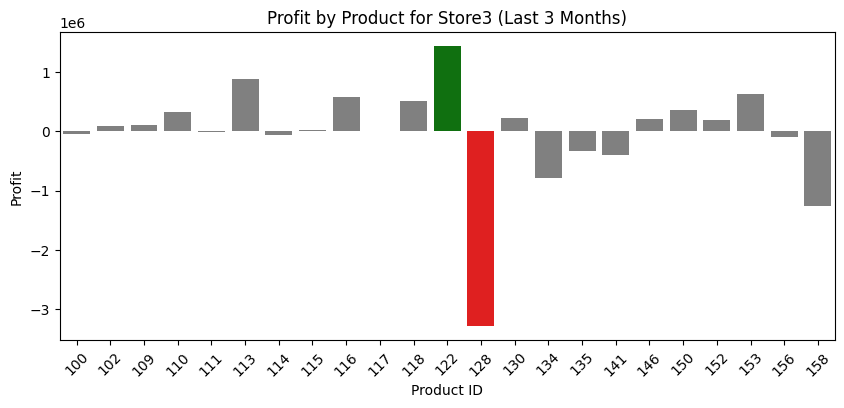

In [146]:
plt.figure(figsize=(10, 4))
sns.barplot(x='Productid', y='Profit', data=sales_store_aggregated, palette=['grey'])
plt.xticks(rotation=45)

# Highlight the most and least profitable products
highlight = sales_store_aggregated[sales_store_aggregated['Productid'].isin([most_profitable_product['Productid'].values[0], least_profitable_product['Productid'].values[0]])]
sns.barplot(x='Productid', y='Profit', data=highlight, palette=['green', 'red'])

plt.title('Profit by Product for Store3 (Last 3 Months)')
plt.xlabel('Product ID')
plt.ylabel('Profit')
plt.show()